In [1]:
from PipelineResources import * # This is where we have all of the resources that will be used in the project. 

The problem occurs because either compilation failed when you installed Somoclu or a path is missing from the dependencies when you are trying to import it. Please refer to the documentation to see your options.


In [4]:
nasdaq = pd.read_pickle('upm_yahoo.pckl')

## Prepare training, validation and test sets

### First Test: Use a CNN Model to predict whether or not the next day will close above 1.5 %. 
The goal behind this exercise is to establish a baseline model and performance. In addition, it is also work out the way the data will be stored. 

In [5]:
number_of_samples = nasdaq.index.size
print(" Sample size is: {}".format(number_of_samples))

 Sample size is: 4755


In [15]:
chosen_features

['open_change',
 'next_day_open_change',
 'open_change_wrt_close',
 'next_day_open_change_wrt_close',
 'high_change',
 'low_change',
 'volume_change',
 'high_low_range',
 'close_change',
 'high_low_range_with_ref_close',
 'high_low_range_with_ref_open',
 'next_day_open_change_wrt_high',
 'next_day_open_change_wrt_low']

### Here we just import the general dataset

In [7]:

random_state = 1
x_train, x_val, x_test, y_train, y_val, y_test = get_input_sets(nasdaq, chosen_features, chosen_label, x_test=False,
                                                               number_of_days_per_sample=1)
print(x_train.shape)


number of days per samples: 1
(4751,)
[0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0]
[0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
(4751, 13)
(3563, 13)


In [8]:
#x_train, y_train = double_class_rows(x_train, y_train, class_number=1)

In [9]:
x_val, y_val = decrease_class_rows(x_val, y_val, class_number=0, percentage_cut=0.90)
x_train, y_train = decrease_class_rows(x_train, y_train, class_number=0, percentage_cut=0.90)


1075
967
(221,)
(221, 13)
3240
2916
(647,)
(647, 13)


In [97]:
#scaler = MinMaxScaler(feature_range=(0,1))
#scaler.fit(x_train)
#x_train = scaler.transform(x_train)
#x_val = scaler.transform(x_val)

## Modify dataset channels if desired
The current approach is to add a channel with FFT information about the input. 

In [10]:
x_train, x_val, x_test = modify_dataset_channels(x_train, x_val, x_test=False, compute_fft=True, multi_channel=True)

(647, 2, 13)
(221, 2, 13)


In [8]:
#x_train = x_train[:,1,:]
#x_train = x_train.reshape([x_train.shape[0], 1, x_train.shape[1]])
#x_val = x_val[:,1,:]
#x_val = x_val.reshape([x_val.shape[0], 1, x_val.shape[1]])
#print(x_train.shape)

In [11]:
class LSTM_0(nn.Module):
    def __init__(self, n_channels, n_features, n_hidden_d, n_classes,
                lstm_layers=1, dropout=0):
        super(LSTM_0, self).__init__()
        self.name = 'LSTM_0'
        if lstm_layers > 1:
            self.lstm_0 = nn.LSTM(n_features, n_hidden_d, lstm_layers, dropout=dropout)
            #self.lstm_0 = nn.GRU(n_features, n_hidden_d, lstm_layers, dropout=dropout)
        else:
            self.lstm_0 = nn.LSTM(n_features, n_hidden_d, lstm_layers)
        self.fc0 = nn.Linear(n_hidden_d * n_channels, n_classes)
        
    def forward(self, x):
        #bp()
        x = x.float()
        lstm_out, (h,c) = self.lstm_0(x)
        x = self.fc0(lstm_out.view(lstm_out.shape[0], lstm_out.shape[1] * lstm_out.shape[2]))
        #bp()
        x = F.softmax(x, dim=1)
        #x = torch.sigmoid(x)
        return x


In [19]:
model_name = LSTM_0.__name__
device = torch.device('cuda:0')
n_channels = x_train.shape[1]
n_features = x_train.shape[2]
n_hidden_d = 10
n_classes = 2
lstm_layers = 1
dropout = 0.1
net = LSTM_0(n_channels, n_features, n_hidden_d=10, n_classes=2,
            lstm_layers = 1, dropout=dropout)
net.to(device)
criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    #bp()
    input_data = torch.tensor(x_train).float()
    labels = torch.tensor(y_train).long()
    input_data = input_data.to(device)
    labels = labels.to(device)
    print('Shape of the input tensor:', input_data.shape)
    y = net(input_data)
    loss = criterion(y, labels)
    print('loss: {}'.format(loss))
    assert y.shape == torch.Size([y_train.shape[0], 2]), "Bad shape of y: y.shape={}".format(y.shape)

print('The shapes seem to be ok.')


Shape of the input tensor: torch.Size([647, 2, 13])
loss: 0.6929499506950378
The shapes seem to be ok.


  epoch    f1_train    train_loss     dur
-------  ----------  ------------  ------
      1      0.6639        0.6945  0.0331
      2      0.6027        0.6939  0.0273
      3      0.0243        0.6935  0.0270
      4      0.0183        0.6931  0.0270
      5      0.0737        0.6929  0.0269
      6      0.1878        0.6929  0.0271
      7      0.5178        0.6928  0.0285
      8      0.6625        0.6924  0.0265
      9      0.6667        0.6924  0.0270
     10      0.6680        0.6919  0.0268
     11      0.6660        0.6925  0.0261
     12      0.6660        0.6923  0.0268
     13      0.6653        0.6916  0.0265
     14      0.6660        0.6915  0.0268
     15      0.6588        0.6910  0.0269
     16      0.6411        0.6903  0.0223
     17      0.6316        0.6899  0.0243
     18      0.6076        0.6891  0.0241
     19      0.5601        0.6885  0.0276
     20      0.5884        0.6875  0.0295
     21      0.5805        0.6871  0.0275
     22      0.6195        0.6859 

    173      0.7284        0.5810  0.0305
    174      0.7041        0.5786  0.0298
    175      0.6620        0.5859  0.0232
    176      0.6848        0.5787  0.0226
    177      0.7085        0.5793  0.0287
    178      0.7179        0.5796  0.0279
    179      0.7134        0.5793  0.0295
    180      0.7093        0.5779  0.0291
    181      0.7044        0.5802  0.0291
    182      0.7083        0.5798  0.0297
    183      0.7273        0.5794  0.0274
    184      0.7116        0.5800  0.0292
    185      0.6548        0.5856  0.0271
    186      0.6607        0.5851  0.0287
    187      0.7150        0.5752  0.0293
    188      0.7221        0.5848  0.0297
    189      0.7300        0.5811  0.0293
    190      0.7040        0.5791  0.0258
    191      0.7013        0.5774  0.0245
    192      0.7131        0.5795  0.0255
    193      0.7111        0.5816  0.0232
    194      0.7267        0.5766  0.0210
    195      0.7132        0.5784  0.0215
    196      0.7057        0.5770 

    365      0.7292        0.5760  0.0238
    366      0.7298        0.5723  0.0248
    367      0.7039        0.5747  0.0234
    368      0.7069        0.5741  0.0251
    369      0.7221        0.5707  0.0233
    370      0.7314        0.5736  0.0259
    371      0.7304        0.5718  0.0253
    372      0.7166        0.5741  0.0275
    373      0.7166        0.5749  0.0260
    374      0.7252        0.5720  0.0278
    375      0.7250        0.5741  0.0286
    376      0.7284        0.5701  0.0252
    377      0.7097        0.5768  0.0225
    378      0.7089        0.5777  0.0268
    379      0.7304        0.5741  0.0244
    380      0.7256        0.5703  0.0243
    381      0.7192        0.5748  0.0247
    382      0.7230        0.5757  0.0264
    383      0.7074        0.5738  0.0290
    384      0.7267        0.5733  0.0257
    385      0.7296        0.5696  0.0223
    386      0.7126        0.5759  0.0232
    387      0.7124        0.5762  0.0244
    388      0.7276        0.5765 

<Figure size 432x288 with 0 Axes>

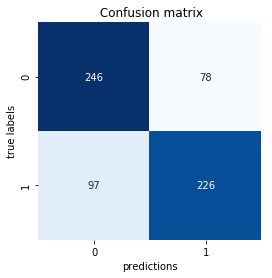

<Figure size 432x288 with 0 Axes>

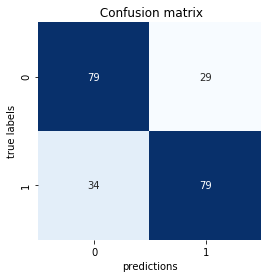

In [14]:
model = None
n_channels = x_train.shape[1]
n_features = x_train.shape[2]
n_hidden_d = 5
n_classes = 2
lstm_layers = 1
dropout = 0.1
device = torch.device('cuda:0')
accuracy_epoch_scoring_val = EpochScoring(scoring='f1',name='f1_val', lower_is_better=False, on_train=False)
accuracy_epoch_scoring_train = EpochScoring(scoring='f1',name='f1_train', lower_is_better=False, on_train=True)
n_epochs = 500

model_name = LSTM_0.__name__
model = NeuralNetClassifier(module=LSTM_0, criterion=nn.CrossEntropyLoss,
                          module__n_channels=n_channels,
                          module__n_features=n_features,
                          module__n_hidden_d=n_hidden_d,
                          module__n_classes=n_classes,
                          module__lstm_layers=lstm_layers,
                          module__dropout= dropout,
                          optimizer=optim.Adam, 
                          optimizer__lr=0.01,
                          #optimizer__weight_decay=0.001,
                          max_epochs=n_epochs, 
                          batch_size=200,
                          iterator_train__shuffle=True,
                          device=device,
                          warm_start=True,train_split=None,
                          callbacks=[accuracy_epoch_scoring_val, accuracy_epoch_scoring_train],
                         )
"""noise_rounds = 10
for _ in range(noise_rounds):
    x_noise = add_noise(x, noise_distribution=np.random.normal, std=np.random.uniform(0,1))
    #x_noise = add_noise(x)
    net.partial_fit(x_noise, y)

    #net.partial_fit(x,y)
"""
model.fit(x_train, y_train)
pred_test = model.predict(x_train)  # Predict labels of test data using the trained classifier
accuracy_of_net = plot_confusion_matrix(pred_test, y_train, prefix_information=model_name,
                          dataset_name='train', save_results=False,
                     y_pred_is_predicted_classes=True)
pred_test = model.predict(x_val)  # Predict labels of test data using the trained classifier
accuracy_of_net = plot_confusion_matrix(pred_test, y_val, prefix_information=model_name,
                          dataset_name='val', save_results=False,
                     y_pred_is_predicted_classes=True)



In [17]:
nasdaq

,Date,Open,High,Low,Close,Adj Close,Volume,open_change,open_change_pct,next_day_open_change,...,volume_change_pct,volume_change,high_low_range,high_low_range_with_ref_open,high_low_range_with_ref_open_pct,high_low_range_with_ref_close,high_low_range_with_ref_close_pct,gt_1,gt_1.5,gt_2.5
0,2000-01-03,20.575001,22.000000,20.500000,21.100000,6.877053,601912.0,0.000000,0.000000,0.025516,...,0.000000,0.000000,1.500000,0.072904,7.290401,0.071090,7.109005,False,False,False
1,2000-01-04,21.100000,21.549999,20.100000,21.549999,7.023720,1412912.0,0.025516,2.551635,0.018957,...,134.737304,1.347373,1.449999,0.068720,6.872033,0.067285,6.728534,True,True,False
2,2000-01-05,21.500000,21.500000,20.000000,21.100000,6.877053,670824.0,0.018957,1.895735,-0.018605,...,-52.521884,-0.525219,1.500000,0.069767,6.976744,0.071090,7.109005,False,False,False
5,2000-01-10,21.500000,21.950001,21.200001,21.299999,6.942239,1800878.0,0.000000,0.000000,-0.005814,...,-9.454205,-0.094542,0.750000,0.034884,3.488372,0.035211,3.521127,True,True,False
6,2000-01-11,21.375000,21.600000,20.250000,20.400000,6.648907,1875000.0,-0.005814,-0.581395,-0.064327,...,4.115881,0.041159,1.350000,0.063158,6.315789,0.066176,6.617647,False,False,False
7,2000-01-12,20.000000,20.250000,19.375000,19.400000,6.322978,1187362.0,-0.064327,-6.432749,0.000000,...,-36.674027,-0.366740,0.875000,0.043750,4.375000,0.045103,4.510309,False,False,False
8,2000-01-13,20.000000,20.350000,19.700001,19.995001,6.516905,1132234.0,0.000000,0.000000,0.000000,...,-4.642897,-0.046429,0.649999,0.032500,3.249995,0.032508,3.250808,True,True,True
9,2000-01-14,20.000000,20.600000,19.900000,20.500000,6.681498,745568.0,0.000000,0.000000,0.026250,...,-34.150714,-0.341507,0.700000,0.035000,3.500000,0.034146,3.414634,True,True,True
10,2000-01-17,20.525000,21.200001,20.525000,20.950001,6.828163,1126256.0,0.026250,2.625000,0.021194,...,51.060131,0.510601,0.675001,0.032887,3.288677,0.032220,3.221962,True,True,False
11,2000-01-18,20.959999,21.100000,20.775000,20.775000,6.771129,1148256.0,0.021194,2.119362,-0.007634,...,1.953375,0.019534,0.325000,0.015506,1.550573,0.015644,1.564380,False,False,False


In [18]:
test_input_df = nasdaq[chosen_features]
test_input = test_input_df.loc[test_input_df.index.size]
print(test_input)
model.predict(test_input.values)

open_change                       0.003460
next_day_open_change             -0.003762
open_change_wrt_close             0.005675
next_day_open_change_wrt_close    0.001260
high_change                      -0.004059
low_change                       -0.003811
volume_change                    -0.280394
high_low_range                    0.529999
close_change                      0.000631
high_low_range_with_ref_close     0.016698
high_low_range_with_ref_open      0.016614
next_day_open_change_wrt_high    -0.003762
next_day_open_change_wrt_low      0.013070
Name: 4755, dtype: float64


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

Accuracy of Net: 0.93

Classification report:
             precision    recall  f1-score   support

          0       0.91      0.98      0.94       340
          1       0.96      0.82      0.88       182

avg / total       0.93      0.93      0.92       522

Accuracy of Net: 0.78

Classification report:
             precision    recall  f1-score   support

          0       0.80      0.87      0.83       113
          1       0.73      0.62      0.67        64

avg / total       0.78      0.78      0.78       177



<Figure size 432x288 with 0 Axes>

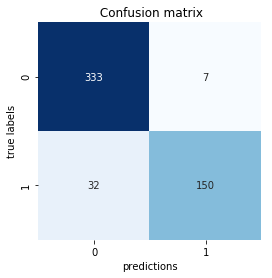

<Figure size 432x288 with 0 Axes>

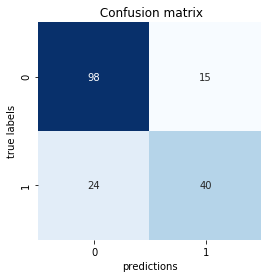

In [35]:
pred_test = model.predict(x_train)  # Predict labels of test data using the trained classifier
accuracy_of_net = plot_confusion_matrix(pred_test, y_train, prefix_information=model_name,
                          dataset_name='train', save_results=False,
                     y_pred_is_predicted_classes=True)
plt.savefig(fname='latex/figures/' + 'LSTM_Training_results' + '.pdf', format='pdf', dpi=300)
pred_test = model.predict(x_val)  # Predict labels of test data using the trained classifier
accuracy_of_net = plot_confusion_matrix(pred_test, y_val, prefix_information=model_name,
                          dataset_name='val', save_results=False,
                     y_pred_is_predicted_classes=True)
plt.savefig(fname='latex/figures/' + 'LSTM_Test_results' + '.pdf', format='pdf', dpi=300)

### Hyper Parameter Optimization

In [100]:
M = 10
optimizer__lr= np.random.uniform(1e-2, 1e-4, M)
weight_decay = np.random.uniform(1e-2,0.3 , M)
optimizer__weight_decay = np.random.uniform(1e-2,0.3 , M)
max_epochs = np.random.randint(2, 100, M)
mid_layer_channels = np.array(np.random.uniform(5, 64, M), dtype=int)
#batch_size = [4, 10, 20, 30]
optimizers = (optim.SGD, optim.Adam)
#C_k_p_s_1 = ([5, 0, 1],[4, 0, 1], [3, 0, 1], [2, 0, 1], [1, 0, 1])
C_k_p_s_1 = tuple([[np.random.randint(2, 5, size=1)[0],np.random.randint(0, 4, size=1)[0], np.random.randint(1, 2, size=1)[0]]  for _ in range(M)])
C_k_p_s_2 = tuple([[np.random.randint(2, 5, size=1)[0],np.random.randint(0, 4, size=1)[0], np.random.randint(1, 2, size=1)[0]]  for _ in range(M)])
p = [np.random.uniform(0.0, 0.5, size=5) for _ in range(M)]
p.append([0.1,0.1, 0.1, 0.1, 0.1])
p.append([0.0,0.0, 0.0, 0.0, 0.0])
p = tuple(p)
#C_k_p_s_1 = [5, 0, 1], M_k_s_1 = [2, 2], C_k_p_s_2 = [5, 0, 1], M_k_s_2 = [2, 2] 
# mid_layer_channels=16 p=[0.1,0.1, 0.1, 0.1, 0.1]
parameters = {#'optimizer__lr': optimizer__lr, 
    #'optimizer': optimizers, 
    #'optimizer__weight_decay': optimizer__weight_decay,
    'module__C_k_p_s_1': C_k_p_s_1, 
    'module__C_k_p_s_2': C_k_p_s_2,
    #'module__mid_layer_channels': mid_layer_channels, 
    #'module__p': p, 
    #'max_epochs': max_epochs
}
print(parameters)

{'module__C_k_p_s_1': ([2, 3, 1], [3, 0, 1], [4, 0, 1], [3, 3, 1], [2, 2, 1], [3, 1, 1], [4, 2, 1], [3, 3, 1], [2, 0, 1], [2, 1, 1]), 'module__C_k_p_s_2': ([4, 0, 1], [2, 1, 1], [2, 3, 1], [4, 0, 1], [2, 2, 1], [3, 2, 1], [2, 3, 1], [4, 2, 1], [2, 1, 1], [3, 2, 1])}


In [99]:
## net = None
rs = None
accuracy_train_epoch_scoring = EpochScoring(scoring='f1', lower_is_better=False, on_train=False)
device = torch.device('cuda:0')
n_channels = x_train.shape[1]
n_features = x_train.shape[2]
n_epochs = 100
kernel_size = 2
padding_size = 1
net = NeuralNetClassifier(module=LeNet5, criterion=nn.CrossEntropyLoss,
                          module__n_channels= n_channels,
                          module__n_features=n_features,
                          module__C_k_p_s_1=[kernel_size,padding_size,1],
                          module__M_k_s_1=[2, 2],
                          module__M_k_s_2=[2, 2],
                          module__C_k_p_s_2=[kernel_size,padding_size,1],
                          #module__p = [0.1, 0.1, 0.1, 0.1, 0.1],
                          module__mid_layer_channels=33,
                          optimizer=optim.Adam, 
                          optimizer__lr = 0.008,
                          #optimizer__weight_decay=0.01,
                          max_epochs=n_epochs, 
                          batch_size=50,
                          iterator_train__shuffle=False,
                          device=device,
                          warm_start=True,#train_split=None,
                          callbacks=[accuracy_epoch_scoring],
                         )
model_name = LeNet5.__name__
rs = RandomizedSearchCV(net, parameters, refit=True, 
                        n_iter=10, n_jobs=1,
                       cv=3, scoring='f1')
#rs = GridSearchCV(net, parameters, n_jobs=1, refit=True, 
#                 scoring='f1', cv=3)
rs.fit(x_train, y_train)
pred_test = rs.predict(x_val)  # Predict labels of test data using the trained classifier
accuracy_of_net = plot_confusion_matrix(pred_test, y_val, prefix_information='RF',
                          dataset_name='', save_results=False,
                     y_pred_is_predicted_classes=True)

  epoch      f1    train_loss    valid_acc    valid_loss     dur
-------  ------  ------------  -----------  ------------  ------
      1  0.0000        0.5306       0.7794        0.5064  0.1300
      2  0.0000        0.5091       0.7794        0.5166  0.1292


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      3  0.0000        0.5083       0.7794        0.5142  0.1328
      4  0.0000        0.5059       0.7794        0.5068  0.1345


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      5  0.0000        0.5031       0.7794        0.5041  0.1332
      6  0.0000        0.5020       0.7794        0.5014  0.1333


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      7  0.0000        0.5011       0.7794        0.5041  0.1493
      8  0.0000        0.5018       0.7794        0.5027  0.1549


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      9  0.0000        0.5000       0.7794        0.5028  0.1477
     10  0.0000        0.5000       0.7794        0.5015  0.1306


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     11  0.0000        0.4979       0.7794        0.5001  0.1683
     12  0.0000        0.4978       0.7794        0.5010  0.1801


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     13  0.0000        0.4972       0.7794        0.5025  0.1540
     14  0.0492        0.4947       0.7832        0.5014  0.1431


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     15  0.0331        0.4939       0.7813        0.4993  0.1486
     16  0.1481        0.4900       0.7850        0.4856  0.1324
     17  0.0794        0.4798       0.7832        0.4746  0.1440
     18  0.3106        0.4641       0.7925        0.4567  0.1347
     19  0.4731        0.4504       0.8168        0.4477  0.1326
     20  0.4848        0.4554       0.8093        0.4412  0.1450
     21  0.5047        0.4584       0.8019        0.4393  0.1454
     22  0.5025        0.4421       0.8150        0.4379  0.1452
     23  0.4951        0.4293       0.8056        0.4424  0.1461
     24  0.5000        0.4200       0.8168        0.4318  0.1380
     25  0.5121        0.4209       0.8112        0.4390  0.1418
     26  0.5297        0.4238       0.8075        0.4484  0.1386
     27  0.5403        0.4320       0.7869        0.4955  0.1455
     28  0.5417        0.4302       0.7944        0.4615  0.1464
     29  0.5417        0.4129       0.7944        0.4638  0.1495
     30  0.5417        0.

/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      3  0.0000        0.4993       0.7888        0.5134  0.1516
      4  0.0000        0.4939       0.7888        0.5117  0.1480


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


  epoch      f1    train_loss    valid_acc    valid_loss     dur
-------  ------  ------------  -----------  ------------  ------
      1  0.0000        0.5355       0.7925        0.5023  0.1445
      2  0.0000        0.4960       0.7925        0.4954  0.1405


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      3  0.0000        0.4875       0.7925        0.4944  0.1478
      4  0.0000        0.4847       0.7925        0.4965  0.1402


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      5  0.0000        0.4840       0.7925        0.4990  0.1379
      6  0.0000        0.4857       0.7925        0.5016  0.1367


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      7  0.0000        0.4877       0.7925        0.4981  0.1519
      8  0.0000        0.4854       0.7925        0.4978  0.1742


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      9  0.0000        0.4822       0.7925        0.4987  0.1650
     10  0.0000        0.4798       0.7925        0.4979  0.1279


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     11  0.0513        0.4792       0.7925        0.4971  0.1326
     12  0.0522        0.4796       0.7963        0.4940  0.1378
     13  0.0179        0.4788       0.7944        0.4945  0.1699
     14  0.0351        0.4767       0.7944        0.4918  0.1462
     15  0.0678        0.4734       0.7944        0.4892  0.1414
     16  0.0513        0.4732       0.7925        0.4906  0.1849
     17  0.0833        0.4658       0.7944        0.4827  0.1743
     18  0.1270        0.4583       0.7944        0.4770  0.1649
     19  0.2958        0.4491       0.8131        0.4710  0.1710
     20  0.3537        0.4410       0.8019        0.4707  0.1761
     21  0.3908        0.4325       0.8019        0.4623  0.1584
     22  0.4815        0.4329       0.7907        0.4902  0.1690
     23  0.4410        0.4297       0.7963        0.4707  0.1861
     24  0.4700        0.4226       0.8019        0.4725  0.1906
     25  0.4623        0.4193       0.8000        0.4729  0.1896
     26  0.4523        0.

/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      4  0.0000        0.5079       0.7794        0.5146  0.1688


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      5  0.0000        0.5052       0.7794        0.5074  0.1882
      6  0.0000        0.5029       0.7794        0.5041  0.1625


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      7  0.0000        0.5021       0.7794        0.5045  0.1851
      8  0.0000        0.5019       0.7794        0.5014  0.1615


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      9  0.0000        0.5001       0.7794        0.5082  0.1574
     10  0.0000        0.5016       0.7794        0.5028  0.1406


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     11  0.0000        0.4994       0.7794        0.5016  0.2014
     12  0.0000        0.5038       0.7794        0.5273  0.1575


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     13  0.0000        0.5046       0.7794        0.5054  0.1329


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     14  0.0000        0.4984       0.7794        0.5014  0.1849
     15  0.0000        0.4972       0.7794        0.4989  0.1480


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     16  0.0000        0.4956       0.7794        0.4982  0.1496


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     17  0.0000        0.4942       0.7794        0.4992  0.1827
     18  0.0000        0.4937       0.7794        0.4983  0.1569


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     19  0.0000        0.4921       0.7794        0.5002  0.1878
     20  0.0000        0.4910       0.7794        0.5040  0.1701


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     21  0.0000        0.4905       0.7794        0.5033  0.1499


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     22  0.0000        0.4884       0.7794        0.4988  0.1795
     23  0.0000        0.4832       0.7794        0.4953  0.1514


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     24  0.0000        0.4765       0.7794        0.4842  0.1480
     25  0.0000        0.4683       0.7794        0.4964  0.1430


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     26  0.4737        0.4690       0.8131        0.4858  0.1797
     27  0.3727        0.4683       0.8112        0.4626  0.1783
     28  0.4900        0.4585       0.8093        0.4861  0.1470
     29  0.4615        0.4671       0.8168        0.5007  0.1336
     30  0.4167        0.4610       0.8168        0.4648  0.1740
     31  0.4878        0.4536       0.8037        0.4746  0.1555
     32  0.4902        0.4518       0.8056        0.4598  0.1406
     33  0.5130        0.4415       0.7907        0.4745  0.1473
     34  0.5045        0.4530       0.7944        0.4810  0.1776
     35  0.5026        0.4483       0.8224        0.4574  0.1496
     36  0.5244        0.4335       0.8000        0.4795  0.1344
     37  0.5138        0.4312       0.8019        0.4627  0.1734
     38  0.5133        0.4303       0.7944        0.4753  0.1478
     39  0.4955        0.4286       0.7907        0.4724  0.1434
     40  0.4683        0.4230       0.7963        0.4669  0.1879
     41  0.5140        0.

/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      3  0.0000        0.4949       0.7888        0.5168  0.1861
      4  0.0000        0.4937       0.7888        0.5178  0.1773


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      5  0.0000        0.4926       0.7888        0.5175  0.1430
      6  0.0000        0.4920       0.7888        0.5169  0.1246


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      7  0.0000        0.4914       0.7888        0.5176  0.1276
      8  0.0000        0.4915       0.7888        0.5171  0.1312


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      9  0.0000        0.4904       0.7888        0.5166  0.1340
     10  0.0000        0.4899       0.7888        0.5165  0.1281


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     11  0.0000        0.4894       0.7888        0.5169  0.1464
     12  0.0000        0.4896       0.7888        0.5176  0.1439


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     13  0.0000        0.4888       0.7888        0.5150  0.1336
     14  0.0000        0.4889       0.7888        0.5156  0.1306


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     15  0.0175        0.4902       0.7907        0.5177  0.1447
     16  0.0504        0.4846       0.7888        0.5161  0.1328
     17  0.0656        0.4848       0.7869        0.5113  0.1444
     18  0.1260        0.4799       0.7925        0.5044  0.1861
     19  0.0656        0.4770       0.7869        0.4958  0.1919
     20  0.1926        0.4685       0.7963        0.4829  0.1398
     21  0.2361        0.4622       0.7944        0.4842  0.1271
     22  0.3165        0.4557       0.7981        0.4694  0.1316
     23  0.2411        0.4611       0.8000        0.4931  0.1305
     24  0.2676        0.4475       0.8056        0.4864  0.1457
     25  0.2981        0.4457       0.7888        0.4990  0.1724
     26  0.4468        0.4487       0.8056        0.4950  0.1576
     27  0.4523        0.4453       0.7963        0.4913  0.1716
     28  0.4513        0.4396       0.8000        0.4879  0.1590
     29  0.4330        0.4343       0.7944        0.4878  0.1290
     30  0.4385        0.

/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      5  0.0000        0.4843       0.7925        0.4986  0.1509
      6  0.0000        0.4826       0.7925        0.4981  0.1273


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      7  0.0000        0.4819       0.7925        0.4971  0.1476
      8  0.0000        0.4814       0.7925        0.4976  0.1439


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      9  0.0000        0.4813       0.7925        0.4987  0.1481
     10  0.0000        0.4808       0.7925        0.4992  0.1330


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     11  0.0000        0.4812       0.7925        0.5006  0.1347
     12  0.0000        0.4819       0.7925        0.5009  0.1308


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     13  0.0000        0.4829       0.7925        0.5058  0.1352
     14  0.0000        0.4846       0.7925        0.5031  0.1429


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     15  0.0000        0.4812       0.7925        0.5033  0.1350
     16  0.0000        0.4841       0.7925        0.5009  0.1394


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     17  0.0000        0.4824       0.7925        0.5075  0.1357
     18  0.0000        0.4836       0.7925        0.5015  0.1360


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     19  0.0000        0.4827       0.7925        0.5024  0.1310
     20  0.0000        0.4792       0.7925        0.5011  0.1319


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     21  0.0000        0.4783       0.7925        0.5029  0.1620


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     22  0.0672        0.4781       0.7925        0.5023  0.1925
     23  0.0000        0.4784       0.7925        0.5018  0.1739
     24  0.0000        0.4771       0.7925        0.5007  0.1494


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     25  0.0000        0.4789       0.7925        0.4993  0.1380
     26  0.0000        0.4774       0.7925        0.5007  0.1310


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     27  0.0000        0.4856       0.7925        0.5009  0.1384
     28  0.0000        0.4784       0.7925        0.5009  0.1505


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     29  0.0000        0.4766       0.7925        0.5002  0.1845
     30  0.0000        0.4768       0.7925        0.4997  0.1745


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     31  0.0000        0.4763       0.7925        0.4972  0.1492
     32  0.0000        0.4757       0.7925        0.4969  0.1451


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     33  0.0000        0.4745       0.7925        0.4993  0.1609


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     34  0.0000        0.4738       0.7925        0.4956  0.1855
     35  0.0000        0.4748       0.7925        0.4953  0.1545


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     36  0.0000        0.4720       0.7925        0.4919  0.1418
     37  0.0000        0.4683       0.7925        0.4854  0.1250


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     38  0.0000        0.4706       0.7925        0.4875  0.1286
     39  0.0000        0.4685       0.7925        0.4884  0.1502


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     40  0.0000        0.4677       0.7925        0.4887  0.1899
     41  0.0000        0.4628       0.7925        0.4826  0.1600


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     42  0.3077        0.4646       0.7981        0.4817  0.1510
     43  0.0000        0.4552       0.7925        0.4732  0.1721


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     44  0.0000        0.4690       0.7925        0.4879  0.1818
     45  0.0000        0.4547       0.7925        0.4784  0.1582


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     46  0.0000        0.4510       0.7925        0.4725  0.1487
     47  0.0000        0.4464       0.7925        0.4751  0.1672


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     48  0.0000        0.4496       0.7925        0.4725  0.1586
     49  0.0000        0.4475       0.7925        0.4749  0.1393


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     50  0.3750        0.4348       0.7757        0.4703  0.1789
     51  0.3819        0.4472       0.7701        0.4625  0.1538
     52  0.3941        0.4331       0.7701        0.4649  0.1598
     53  0.3895        0.4306       0.7832        0.4628  0.1691
     54  0.4255        0.4318       0.7981        0.4671  0.1407
     55  0.4227        0.4220       0.7907        0.4544  0.1273
     56  0.4108        0.4300       0.7963        0.4608  0.1267
     57  0.4000        0.4166       0.8206        0.4675  0.1271
     58  0.3911        0.4183       0.7963        0.4627  0.1436
     59  0.3882        0.4185       0.8056        0.4652  0.1320
     60  0.3681        0.4221       0.8075        0.4612  0.1348
     61  0.4706        0.4163       0.8150        0.4618  0.1272
     62  0.4125        0.4063       0.8243        0.4526  0.1268
     63  0.4068        0.4222       0.8037        0.4591  0.1427
     64  0.2647        0.4084       0.8131        0.4505  0.1420
     65  0.2763        0.

/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      3  0.0000        0.5040       0.7794        0.5048  0.1523
      4  0.0000        0.5035       0.7794        0.5059  0.1325


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      5  0.0000        0.5011       0.7794        0.5014  0.1344
      6  0.0000        0.4997       0.7794        0.5030  0.1488


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      7  0.0000        0.4991       0.7794        0.5002  0.1457
      8  0.0000        0.4914       0.7794        0.4985  0.1334


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      9  0.0000        0.4878       0.7794        0.4852  0.1335
     10  0.0000        0.4773       0.7794        0.4645  0.1318


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     11  0.0000        0.4512       0.7794        0.4594  0.1453
     12  0.2621        0.4335       0.8000        0.4188  0.1307


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     13  0.4599        0.4276       0.8112        0.4093  0.1366
     14  0.5000        0.4294       0.8056        0.4095  0.1424
     15  0.5542        0.4295       0.7925        0.4224  0.1410
     16  0.4681        0.4144       0.8131        0.4071  0.1345
     17  0.5352        0.4164       0.8150        0.3981  0.1258
     18  0.5171        0.4135       0.8150        0.4106  0.1257
     19  0.4894        0.4065       0.8206        0.4079  0.1304
     20  0.5446        0.4096       0.8093        0.3996  0.1348
     21  0.5209        0.4068       0.8075        0.4073  0.1307
     22  0.5258        0.4038       0.8112        0.4138  0.1407
     23  0.5308        0.4009       0.8150        0.4030  0.1254
     24  0.5488        0.3986       0.8187        0.4027  0.1262
     25  0.5238        0.3978       0.8131        0.4031  0.1438
     26  0.5403        0.3987       0.8187        0.4098  0.1426
     27  0.5052        0.3932       0.8206        0.4011  0.1415
     28  0.5288        0.

/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      3  0.0000        0.4923       0.7888        0.5151  0.1654
      4  0.0000        0.4903       0.7888        0.5145  0.1699


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      5  0.0000        0.4898       0.7888        0.5130  0.1361
      6  0.0000        0.4888       0.7888        0.5121  0.1303


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      7  0.0000        0.4882       0.7888        0.5118  0.1299
      8  0.0175        0.4875       0.7907        0.5108  0.1332


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      9  0.0174        0.4867       0.7888        0.5104  0.1377
     10  0.0174        0.4857       0.7888        0.5098  0.1327
     11  0.0174        0.4847       0.7888        0.5088  0.1239
     12  0.0174        0.4839       0.7888        0.5082  0.1418
     13  0.0345        0.4820       0.7907        0.5055  0.1327
     14  0.0174        0.4800       0.7888        0.4929  0.1334
     15  0.0174        0.4838       0.7888        0.4960  0.1314
     16  0.0342        0.4673       0.7888        0.4626  0.1302
     17  0.0513        0.5087       0.7925        0.4938  0.1304
     18  0.0175        0.4719       0.7907        0.4868  0.1364
     19  0.0508        0.4547       0.7907        0.4370  0.1354
     20  0.3234        0.4886       0.7888        0.4773  0.1236
     21  0.4687        0.4443       0.8093        0.4234  0.1248
     22  0.5045        0.4518       0.7944        0.4398  0.1230
     23  0.5455        0.4244       0.8224        0.4025  0.1360
     24  0.5143        0.

/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      3  0.0000        0.4892       0.7925        0.4971  0.1406
      4  0.0000        0.4863       0.7925        0.4964  0.1323


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      5  0.0000        0.4846       0.7925        0.4996  0.1369
      6  0.0000        0.4840       0.7925        0.4984  0.1333


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      7  0.0000        0.4821       0.7925        0.5019  0.1477
      8  0.0000        0.4811       0.7925        0.5007  0.1445


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      9  0.0000        0.4792       0.7925        0.4993  0.1477
     10  0.0000        0.4804       0.7925        0.4974  0.1454


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     11  0.0000        0.4764       0.7925        0.4965  0.1382
     12  0.0000        0.4786       0.7925        0.4953  0.1331


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     13  0.0000        0.4745       0.7925        0.4908  0.1415
     14  0.0000        0.4638       0.7925        0.4832  0.1399


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     15  0.0000        0.4453       0.7925        0.4826  0.1630
     16  0.0000        0.4379       0.7925        0.4681  0.1667


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     17  0.3871        0.4310       0.7869        0.4628  0.1627
     18  0.3468        0.4293       0.7888        0.4634  0.1670
     19  0.4062        0.4186       0.7869        0.4583  0.1702
     20  0.3895        0.4159       0.7832        0.4555  0.1311
     21  0.4061        0.4136       0.7813        0.4513  0.1244
     22  0.4000        0.4133       0.7925        0.4549  0.1241
     23  0.3977        0.4084       0.8019        0.4425  0.1294
     24  0.3978        0.4059       0.7963        0.4418  0.1281
     25  0.4271        0.4026       0.7944        0.4446  0.1274
     26  0.4316        0.4036       0.7981        0.4405  0.1243
     27  0.4516        0.4003       0.8093        0.4378  0.1246
     28  0.4293        0.3981       0.7963        0.4429  0.1364
     29  0.4045        0.3966       0.8019        0.4301  0.1336
     30  0.3931        0.3964       0.8037        0.4401  0.1354
     31  0.3886        0.3916       0.8000        0.4310  0.1328
     32  0.4199        0.

/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      3  0.0168        0.5053       0.7813        0.5055  0.1399
      4  0.0000        0.5059       0.7794        0.5143  0.1367
      5  0.0000        0.5050       0.7794        0.5131  0.1772


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      6  0.0000        0.5019       0.7794        0.5072  0.1703
      7  0.0000        0.4995       0.7794        0.5053  0.1531


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      8  0.0000        0.4986       0.7794        0.5054  0.1593
      9  0.0333        0.4977       0.7832        0.5055  0.1393


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     10  0.1085        0.4945       0.7850        0.5033  0.1216
     11  0.0800        0.4916       0.7850        0.5011  0.1259
     12  0.0640        0.4888       0.7813        0.5017  0.1457
     13  0.0640        0.4865       0.7813        0.4998  0.1453
     14  0.1240        0.4800       0.7888        0.4783  0.1467
     15  0.2329        0.4702       0.7907        0.4652  0.1370
     16  0.2667        0.4680       0.7944        0.4651  0.1348
     17  0.3270        0.4630       0.8000        0.4555  0.1239
     18  0.3793        0.4601       0.7981        0.4649  0.1197
     19  0.3007        0.4482       0.8000        0.4350  0.1204
     20  0.3436        0.4409       0.8000        0.4299  0.1196
     21  0.4316        0.4440       0.7981        0.4480  0.1192
     22  0.4469        0.4398       0.8150        0.4393  0.1198
     23  0.3977        0.4300       0.8075        0.4223  0.1225
     24  0.4870        0.4323       0.8150        0.4134  0.1232
     25  0.4762        0.

/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      3  0.0000        0.4927       0.7888        0.5150  0.1322
      4  0.0000        0.4908       0.7888        0.5181  0.1262


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      5  0.0000        0.4882       0.7888        0.5119  0.1277
      6  0.0000        0.4843       0.7888        0.5075  0.1313


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      7  0.0000        0.4820       0.7888        0.5038  0.1278
      8  0.0000        0.4799       0.7888        0.5014  0.1378


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      9  0.0000        0.4744       0.7888        0.4953  0.1442
     10  0.0000        0.4746       0.7888        0.4906  0.1414


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     11  0.0000        0.4720       0.7888        0.4845  0.1443
     12  0.0000        0.4675       0.7888        0.4860  0.1286


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     13  0.0000        0.4723       0.7888        0.4883  0.1321
     14  0.0000        0.4506       0.7888        0.4718  0.1231


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     15  0.0000        0.4482       0.7888        0.4760  0.1346
     16  0.4293        0.4467       0.7963        0.4745  0.1451


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     17  0.4433        0.4401       0.7888        0.4685  0.1325
     18  0.4513        0.4419       0.8000        0.4648  0.1321
     19  0.4683        0.4370       0.7963        0.4574  0.1448
     20  0.4510        0.4367       0.7907        0.4669  0.1300
     21  0.4064        0.4339       0.7925        0.4587  0.1287
     22  0.4739        0.4332       0.7925        0.4560  0.1194
     23  0.4677        0.4293       0.8000        0.4527  0.1317
     24  0.4909        0.4270       0.7907        0.4623  0.1279
     25  0.4683        0.4237       0.7963        0.4537  0.1224
     26  0.4909        0.4225       0.7907        0.4561  0.1556
     27  0.4673        0.4212       0.7869        0.4597  0.1752
     28  0.4787        0.4163       0.8168        0.4325  0.1734
     29  0.4932        0.4207       0.7925        0.4522  0.1749
     30  0.5023        0.4111       0.7963        0.4372  0.1622
     31  0.5094        0.4200       0.8056        0.4348  0.1684
     32  0.5045        0.

/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      4  0.0513        0.4830       0.7925        0.4986  0.1302
      5  0.0000        0.4830       0.7925        0.4990  0.1271
      6  0.0000        0.4806       0.7925        0.4965  0.1278


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      7  0.0000        0.4785       0.7925        0.4958  0.1334
      8  0.0000        0.4751       0.7925        0.4933  0.1350


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      9  0.0000        0.4705       0.7925        0.4899  0.1325
     10  0.0000        0.4676       0.7925        0.4876  0.1283


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     11  0.3253        0.4625       0.7907        0.4879  0.1281
     12  0.2429        0.4538       0.8019        0.4771  0.1317
     13  0.3394        0.4445       0.7963        0.4740  0.1452
     14  0.2968        0.4401       0.7963        0.4578  0.1329
     15  0.3820        0.4286       0.7944        0.4510  0.1391
     16  0.4301        0.4212       0.8019        0.4466  0.1211
     17  0.3830        0.4185       0.7832        0.4557  0.1245
     18  0.3625        0.4138       0.8093        0.4346  0.1353
     19  0.4358        0.4143       0.8112        0.4265  0.1360
     20  0.3729        0.4077       0.7925        0.4302  0.1393
     21  0.3804        0.4095       0.8112        0.4193  0.1302
     22  0.3837        0.4063       0.8019        0.4205  0.1381
     23  0.4677        0.4030       0.8000        0.4164  0.1394
     24  0.3908        0.3972       0.8019        0.4186  0.1261
     25  0.4114        0.4005       0.8075        0.4182  0.1400
     26  0.4157        0.

ZeroDivisionError: float division by zero

In [67]:
rs.best_params_

{'module__C_k_p_s_1': [3, 1, 1], 'module__C_k_p_s_2': [2, 2, 1]}

In [34]:
model_dir_path = 'models'
model_filename = "{:s}/{}_LSTM_model_acc-{:2.3f}_{:s}_FINAL.model".format(
    model_dir_path, 'yahoo_data', accuracy_of_net, strftime("%Y_%m_%d_%H_%M_%S", localtime())
)
pickle.dump(model, open(model_filename, 'wb'))

/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type LSTM_0. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
